# MAPS Summer School – Spatial Error Model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vincnardelli/maps/blob/main/Python/notebooks/2_spatial_error_model_colab.ipynb)

**Data loads automatically from GitHub**

In [2]:
import os
import sys
# Download shapefile data from GitHub
import urllib.request
os.makedirs('data', exist_ok=True)

base_url = 'https://github.com/vincnardelli/maps/raw/main/data/sdr_subnational_data_migration/shps/sdr_subnational_data_dhs_2022_lvl_2'
extensions = ['.shp', '.shx', '.dbf', '.prj']

print('📥 Downloading data from GitHub...')
for ext in extensions:
    url = base_url + ext
    filename = f'data/sdr_subnational_data_dhs_2022_lvl_2{ext}'
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
        print(f'  ✓ {ext}')
    else:
        print(f'  ⊙ {ext} (cached)')

DATA_PATH = 'data/sdr_subnational_data_dhs_2022_lvl_2.shp'
print(f'\n✅ Data ready: {DATA_PATH}')

📥 Downloading data from GitHub...
  ⊙ .shp (cached)
  ✓ .shx
  ✓ .dbf
  ✓ .prj

✅ Data ready: data/sdr_subnational_data_dhs_2022_lvl_2.shp


In [3]:
# Import required packages
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights import Queen
from esda.moran import Moran, Moran_Local
from spreg import OLS
from spreg.ml_error import ML_Error
from scipy.stats import zscore
from scipy.sparse.csgraph import connected_components
import warnings
warnings.filterwarnings('ignore')

np.random.seed(123)
print('✅ Packages loaded')

✅ Packages loaded


### 1) Read polygons and quick data checks

In [4]:
tz = gpd.read_file(DATA_PATH)

print(f"Shape: {tz.shape}")
print(f"\nMigration rate summary (AHMIGRWEMP):")
print(tz['AHMIGRWEMP'].describe())
print(f"\nEducation level summary (EDEDUCWSEH):")
print(tz['EDEDUCWSEH'].describe())

Shape: (31, 49)

Migration rate summary (AHMIGRWEMP):
count    31.000000
mean     12.025806
std       8.667140
min       1.300000
25%       6.200000
50%       8.700000
75%      18.550000
max      31.100000
Name: AHMIGRWEMP, dtype: float64

Education level summary (EDEDUCWSEH):
count    31.000000
mean     34.232258
std      18.446127
min      14.900000
25%      20.450000
50%      26.200000
75%      40.250000
max      79.600000
Name: EDEDUCWSEH, dtype: float64


### 2) Define color scheme for maps

In [5]:
# Color scheme for choropleth maps
cmap_ylrd = 'YlOrRd'

### 3) Exploratory plots

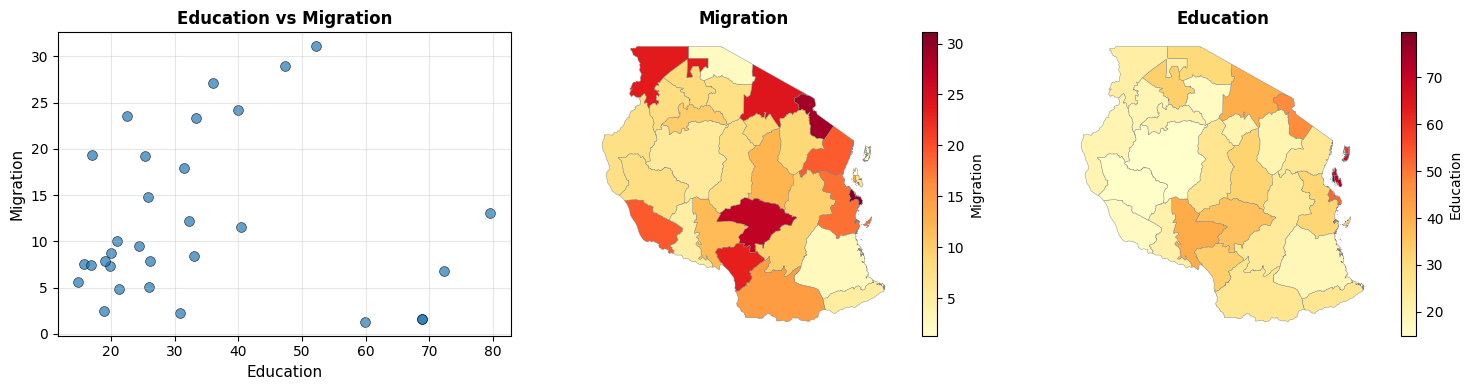

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# 3a) Scatter of education vs migration
ax1.scatter(tz['EDEDUCWSEH'], tz['AHMIGRWEMP'], alpha=0.7, s=50, edgecolors='black', linewidths=0.5)
ax1.set_xlabel('Education', fontsize=11)
ax1.set_ylabel('Migration', fontsize=11)
ax1.set_title('Education vs Migration', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 3b) Choropleth of migration
tz.plot(column='AHMIGRWEMP', cmap=cmap_ylrd, linewidth=0.3,
        edgecolor='grey', legend=True, ax=ax2,
        legend_kwds={'label': 'Migration'})
ax2.set_title('Migration', fontsize=12, fontweight='bold')
ax2.axis('off')

# 3c) Choropleth of education
tz.plot(column='EDEDUCWSEH', cmap=cmap_ylrd, linewidth=0.3,
        edgecolor='grey', legend=True, ax=ax3,
        legend_kwds={'label': 'Education'})
ax3.set_title('Education', fontsize=12, fontweight='bold')
ax3.axis('off')

plt.tight_layout()
plt.show()

### 4) Baseline OLS regression & residual spatial autocorrelation

In [10]:
# Remove missing values
vars_use = ['AHMIGRWEMP', 'EDEDUCWSEH']
tz_clean = tz[vars_use].dropna().copy()
tz_geom = tz.loc[tz_clean.index].copy()
tz_clean.reset_index(drop=True, inplace=True)
tz_geom.reset_index(drop=True, inplace=True)

# Prepare data for regression
y = tz_clean['AHMIGRWEMP'].values.reshape(-1, 1)
X = tz_clean[['EDEDUCWSEH']].values

# Fit OLS model
ols = OLS(y, X, name_y='AHMIGRWEMP', name_x=['EDEDUCWSEH'])

print("="*60)
print("OLS REGRESSION RESULTS (PYTHON)")
print("="*60)
print(ols.summary)
print("="*60)

OLS REGRESSION RESULTS (PYTHON)
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :  AHMIGRWEMP                Number of Observations:          31
Mean dependent var  :     12.0258                Number of Variables   :           2
S.D. dependent var  :      8.6671                Degrees of Freedom    :          29
R-squared           :      0.0000
Adjusted R-squared  :     -0.0345
Sum squared residual:     2253.54                F-statistic           :      0.0005
Sigma-square        :      77.708                Prob(F-statistic)     :      0.9819
S.E. of regression  :       8.815                Log likelihood        :    -110.424
Sigma-square ML     :      72.695                Akaike info criterion :     224.849
S.E of regression ML:      8.5261                Schwarz criterion     :     227.717

----------------------------

### 4b) Plot OLS regression line

Intercept: 11.9575
Slope: 0.001995


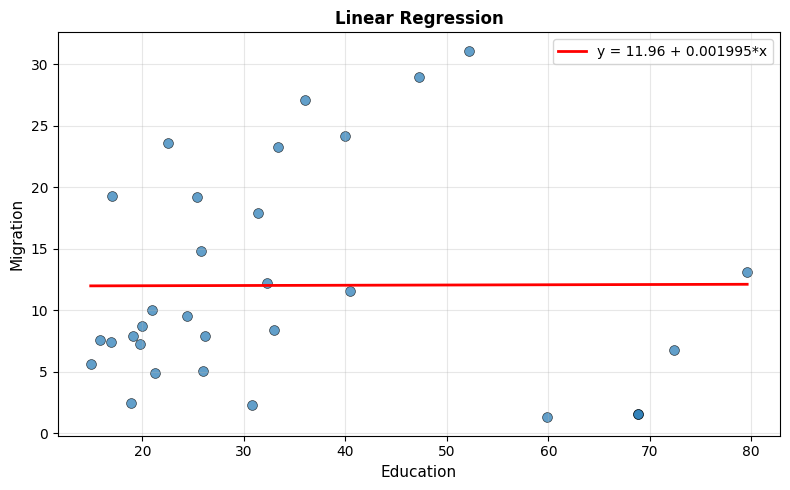

In [11]:
# Extract coefficients
intercept = ols.betas[0][0]
slope = ols.betas[1][0]

print(f"Intercept: {intercept:.4f}")
print(f"Slope: {slope:.6f}")

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(tz_clean['EDEDUCWSEH'], tz_clean['AHMIGRWEMP'],
          alpha=0.7, s=50, edgecolors='black', linewidths=0.5)

# Add regression line
x_range = np.array([tz_clean['EDEDUCWSEH'].min(), tz_clean['EDEDUCWSEH'].max()])
y_pred = intercept + slope * x_range
ax.plot(x_range, y_pred, 'r-', linewidth=2, label=f'y = {intercept:.2f} + {slope:.6f}*x')

ax.set_xlabel('Education', fontsize=11)
ax.set_ylabel('Migration', fontsize=11)
ax.set_title('Linear Regression', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4c) Build spatial weights and test for spatial autocorrelation

In [12]:
# Queen contiguity weights
w_queen = Queen.from_dataframe(tz_geom)
w_queen.transform = 'r'  # row-standardized

print(f"Number of observations: {w_queen.n}")
print(f"Average number of neighbors: {w_queen.mean_neighbors:.2f}")

Number of observations: 31
Average number of neighbors: 4.00


### 4d) Moran's I on OLS residuals

In [13]:
# Get OLS residuals
residuals_ols = ols.u.flatten()

# Moran's I test on residuals
moran_resid = Moran(residuals_ols, w_queen)

print("="*60)
print("MORAN'S I ON OLS RESIDUALS (PYTHON)")
print("="*60)
print(f"Moran's I: {moran_resid.I:.6f}")
print(f"Expected I: {moran_resid.EI:.6f}")
print(f"Z-score: {moran_resid.z_norm:.6f}")
print(f"P-value: {moran_resid.p_norm:.6f}")
print("\nInterpretation: Significant positive spatial autocorrelation")
print("in residuals suggests spatial error model may be appropriate.")
print("="*60)

MORAN'S I ON OLS RESIDUALS (PYTHON)
Moran's I: 0.214935
Expected I: -0.033333
Z-score: 1.822432
P-value: 0.068389

Interpretation: Significant positive spatial autocorrelation
in residuals suggests spatial error model may be appropriate.


### 4e-4g) Visualize OLS residuals

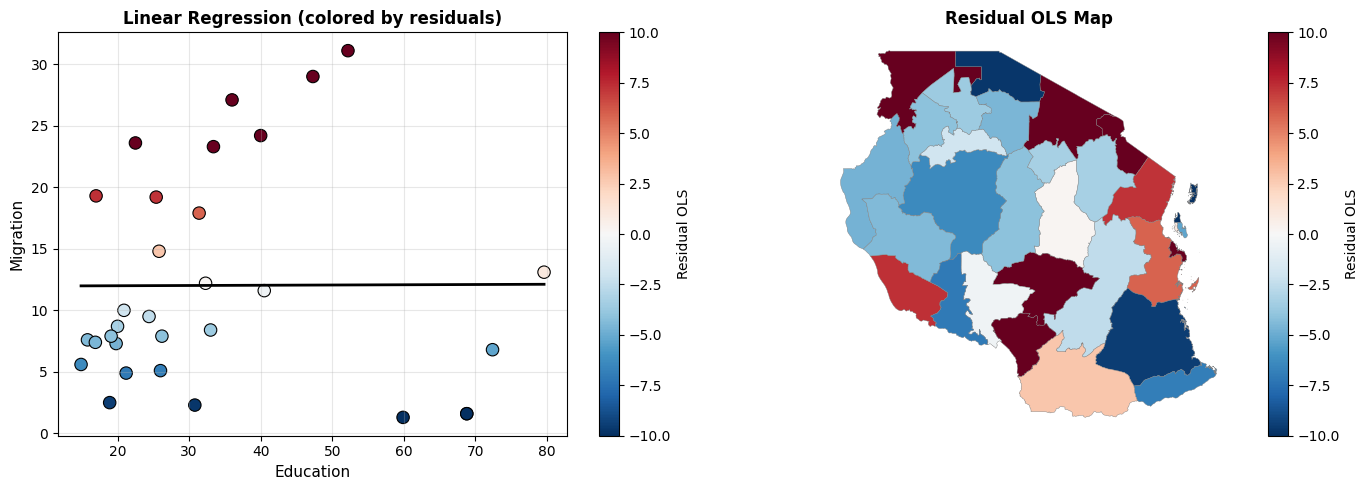

In [14]:
import os
os.makedirs("plots", exist_ok=True)

# Add residuals to geodataframe
tz_geom['residual_ols'] = residuals_ols

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Scatter with residual colors
scatter = ax1.scatter(tz_clean['EDEDUCWSEH'], tz_clean['AHMIGRWEMP'],
                     c=residuals_ols, cmap='RdBu_r', s=80,
                     edgecolors='black', linewidths=0.8, vmin=-10, vmax=10)
ax1.plot(x_range, y_pred, 'k-', linewidth=2)
ax1.set_xlabel('Education', fontsize=11)
ax1.set_ylabel('Migration', fontsize=11)
ax1.set_title('Linear Regression (colored by residuals)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Residual OLS')

# Residual map
tz_geom.plot(column='residual_ols', cmap='RdBu_r', linewidth=0.3,
            edgecolor='grey', legend=True, ax=ax2, vmin=-10, vmax=10,
            legend_kwds={'label': 'Residual OLS'})
ax2.set_title('Residual OLS Map', fontsize=12, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.savefig('plots/model_error_ols_python.pdf', dpi=300, bbox_inches='tight')
plt.show()

### 5) Spatial Error Model (SEM)

Model specification: y = Xβ + u, where u = λWu + ε

The spatial error model accounts for spatial autocorrelation in the error term.

In [23]:
# Fit Spatial Error Model using ML estimation
# Note: Using BaseML_Error directly to avoid summary bug

y_ml = y.reshape(-1, 1)

sem_ml = ML_Error(y=y_ml, x=X, w=w_queen, method='full')
print("="*60)
print("SPATIAL ERROR MODEL RESULTS (PYTHON - ML)")
print("="*60)
print(f"\nCoefficients:")
print(f"  Intercept:   {sem_ml.betas[0][0]:10.5f}")
print(f"  EDEDUCWSEH:  {sem_ml.betas[1][0]:10.5f}")
print(f"\nSpatial parameter:")
print(f"  Lambda (λ):  {sem_ml.lam:10.5f}")
print(f"\nModel fit:")
print(f"  Log-likelihood: {sem_ml.logll:.4f}")
k = len(sem_ml.betas) + 1
aic = -2 * sem_ml.logll + 2 * k
print(f"  AIC: {aic:.2f}")
print(f"  N observations: {sem_ml.n}")
print("="*60)


SPATIAL ERROR MODEL RESULTS (PYTHON - ML)

Coefficients:
  Intercept:      4.62217
  EDEDUCWSEH:     0.24753

Spatial parameter:
  Lambda (λ):     0.60205

Model fit:
  Log-likelihood: -108.1787
  AIC: 224.36
  N observations: 31
